In [1]:
import scanpy as sc
import pandas as pd
import torch

# Metadata: cell-gene pairs
meta_df = pd.read_csv(
    "/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/gene_ids/shard_0/cell_gene_pairs.txt",
    sep="\t", header=None, names=["cell_id", "gene_id"]
)

f1_df = pd.read_csv('/maiziezhou_lab2/yunfei/Projects/FM_temp/interGFM/output/test/heldout_top_pairings.csv', index_col=0)

# SAE Latents
latents_df = pd.read_parquet("/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/activations/layer_4/shard_0/sae_latents.parquet")

# acts 
acts_df = torch.load("/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/activations/layer_4/shard_0/activations.pt")

# Load h5ad to get cell types
adata = sc.read_h5ad("/maiziezhou_lab2/yunfei/Projects/FM_temp/InterPLM/interplm/ge_shards/cosmx_human_lung_sec8.h5ad")
celltype_map = adata.obs["author_cell_type"].to_dict()  # dict: cell_id → cell_type

# Add cell_type to meta_df
meta_df["cell_type"] = meta_df["cell_id"].map(celltype_map)

Features with max_F1 > 0.75: 43


,max_F1,top_concept
feature,,
2430,1.000000,negative regulation of endothelial cell migration
208,1.000000,positive regulation of vascular associated smo...
71,0.972041,regulation of DNA biosynthetic process
1725,0.963731,peptide secretion
1644,0.943667,positive regulation of endothelial cell apopto...
3883,0.928571,alpha-beta T cell activation involved in immun...
108,0.922088,regulation of primary metabolic process
1860,0.921626,response to temperature stimulus
324,0.918412,regulation of natural killer cell mediated imm...


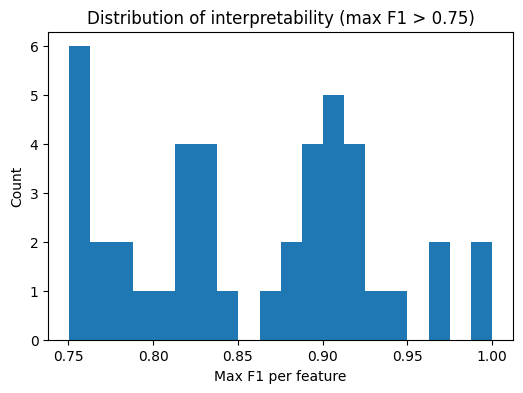

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Group by feature and take the row with the max F1
f1_summary = (
    f1_df.sort_values("f1", ascending=False)
         .groupby("feature")
         .first()  # keep highest-F1 row per feature
)

summary = f1_summary[["f1", "concept"]].rename(
    columns={"f1": "max_F1", "concept": "top_concept"}
).sort_values("max_F1", ascending=False)

# Filter features with max_F1 > 0.75
high_f1_features = summary.query("max_F1 > 0.75")

print(f"Features with max_F1 > 0.75: {len(high_f1_features)}")
display(high_f1_features)

plt.figure(figsize=(6, 4))
plt.hist(high_f1_features["max_F1"], bins=20)
plt.xlabel("Max F1 per feature")
plt.ylabel("Count")
plt.title("Distribution of interpretability (max F1 > 0.75)")
plt.show()

# Optional: save to CSV for inspection
# high_f1_features.to_csv("/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/high_f1_0.75_concepts.csv")


[F1 ≥ 0.50] concepts covered: 392
[F1 ≥ 0.50] features covered: 86
Saved: //maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/figures/interpretable_features_F1_ge_0.50.csv


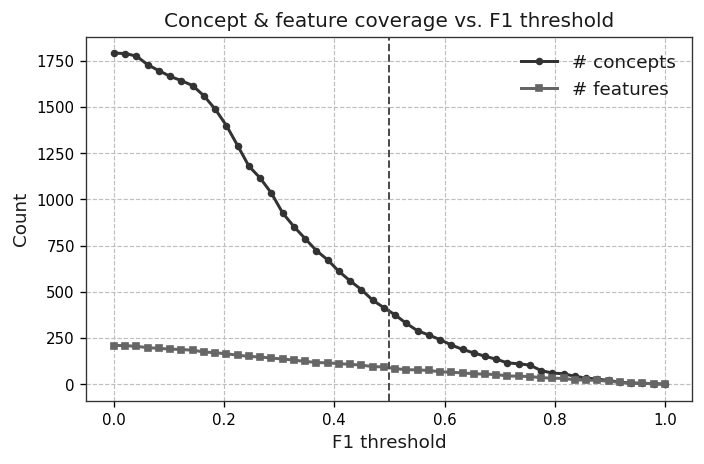

Saved: //maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/figures/f1_coverage_sweep.pdf


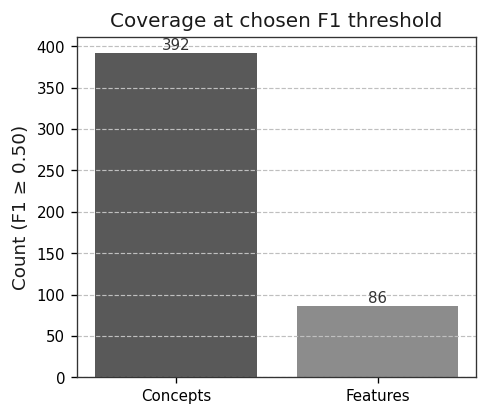

Saved: //maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/figures/f1_coverage_at_0.50.pdf


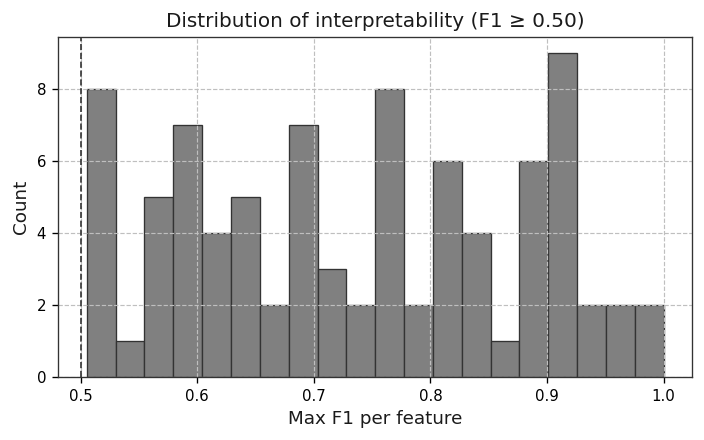

Saved: //maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/figures/interpretable_feature_hist_F1_ge_0.50.pdf


In [2]:
# === F1-based concept–feature coverage @ threshold 0.5 (grayscale, journal-friendly) ===
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

OUTDIR = "//maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/figures"
os.makedirs(OUTDIR, exist_ok=True)

# ---------- 0) consistent grayscale style ----------
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.edgecolor": "0.2",
    "axes.labelcolor": "0.1",
    "text.color": "0.1",
    "grid.color": "0.75",
    "grid.linestyle": "--",
    "grid.linewidth": 0.7,
    "pdf.fonttype": 42,           # TrueType text, not outlines
    "ps.fonttype": 42,
})

# ---------- 1) per-feature max F1 and top concept ----------
f1_summary = (
    f1_df.sort_values("f1", ascending=False)
         .groupby("feature")
         .first()[["f1", "concept"]]
         .rename(columns={"f1": "max_F1", "concept": "top_concept"})
         .sort_values("max_F1", ascending=False)
)

# ---------- 2) choose threshold and compute coverage ----------
THRESH = 0.50
high = f1_df.query("f1 > @THRESH")
n_concepts_t = int(high["concept"].nunique())
n_features_t = int(high["feature"].nunique())

print(f"[F1 ≥ {THRESH:.2f}] concepts covered: {n_concepts_t:,}")
print(f"[F1 ≥ {THRESH:.2f}] features covered: {n_features_t:,}")

# (optional) export the “interpretable” features at this threshold
interpretable_features = (
    f1_summary[f1_summary["max_F1"] > THRESH]
    .reset_index()[["feature","max_F1","top_concept"]]
)
interpretable_csv = os.path.join(OUTDIR, f"interpretable_features_F1_ge_{THRESH:.2f}.csv")
interpretable_features.to_csv(interpretable_csv, index=False)
print("Saved:", interpretable_csv)

# ---------- 3) sweep plot with vertical line at THRESH ----------
thresholds = np.linspace(0, 1, 50)
concept_counts = []
latent_counts  = []

for t in thresholds:
    sub = f1_df[f1_df["f1"] > t]
    concept_counts.append(sub["concept"].nunique())
    latent_counts.append(sub["feature"].nunique())

fig, ax = plt.subplots(figsize=(6.0, 4.0))
ax.plot(thresholds, concept_counts, marker="o", ms=3.5, lw=1.8, color="0.2", label="# concepts")
ax.plot(thresholds, latent_counts,  marker="s", ms=3.5, lw=1.8, color="0.4", label="# features")
ax.axvline(THRESH, ymin=0, ymax=1, color="0.3", linestyle="--", linewidth=1.2)
ax.grid(True)
ax.set_xlabel("F1 threshold")
ax.set_ylabel("Count")
ax.set_title("Concept & feature coverage vs. F1 threshold")
ax.legend(frameon=False)
plt.tight_layout()
pdf1 = os.path.join(OUTDIR, "f1_coverage_sweep.pdf")
fig.savefig(pdf1)
plt.show()
print("Saved:", pdf1)

# ---------- 4) bar chart exactly at THRESH ----------
fig, ax = plt.subplots(figsize=(4.2, 3.6))
bars = ax.bar(["Concepts", "Features"], [n_concepts_t, n_features_t], color=["0.35","0.55"])
for b in bars:
    ax.text(b.get_x()+b.get_width()/2, b.get_height()+0.5, f"{int(b.get_height())}", 
            ha="center", va="bottom", fontsize=9, color="0.2")
ax.set_ylabel(f"Count (F1 ≥ {THRESH:.2f})")
ax.set_title("Coverage at chosen F1 threshold")
ax.grid(axis="y")
plt.tight_layout()
pdf2 = os.path.join(OUTDIR, f"f1_coverage_at_{THRESH:.2f}.pdf")
fig.savefig(pdf2)
plt.show()
print("Saved:", pdf2)

# ---------- 5) (optional) histogram of max_F1 for interpretable features ----------
fig, ax = plt.subplots(figsize=(6.0, 3.8))
vals = f1_summary["max_F1"][f1_summary["max_F1"] > THRESH]
ax.hist(vals, bins=20, color="0.5", edgecolor="0.2", linewidth=0.8)
ax.axvline(THRESH, color="0.2", linestyle="--", linewidth=1.0)
ax.set_xlabel("Max F1 per feature")
ax.set_ylabel("Count")
ax.set_title(f"Distribution of interpretability (F1 ≥ {THRESH:.2f})")
ax.grid(True)
plt.tight_layout()
pdf3 = os.path.join(OUTDIR, f"interpretable_feature_hist_F1_ge_{THRESH:.2f}.pdf")
fig.savefig(pdf3)
plt.show()
print("Saved:", pdf3)

[filter] Dropping 67 overlong concepts (> 6 words).


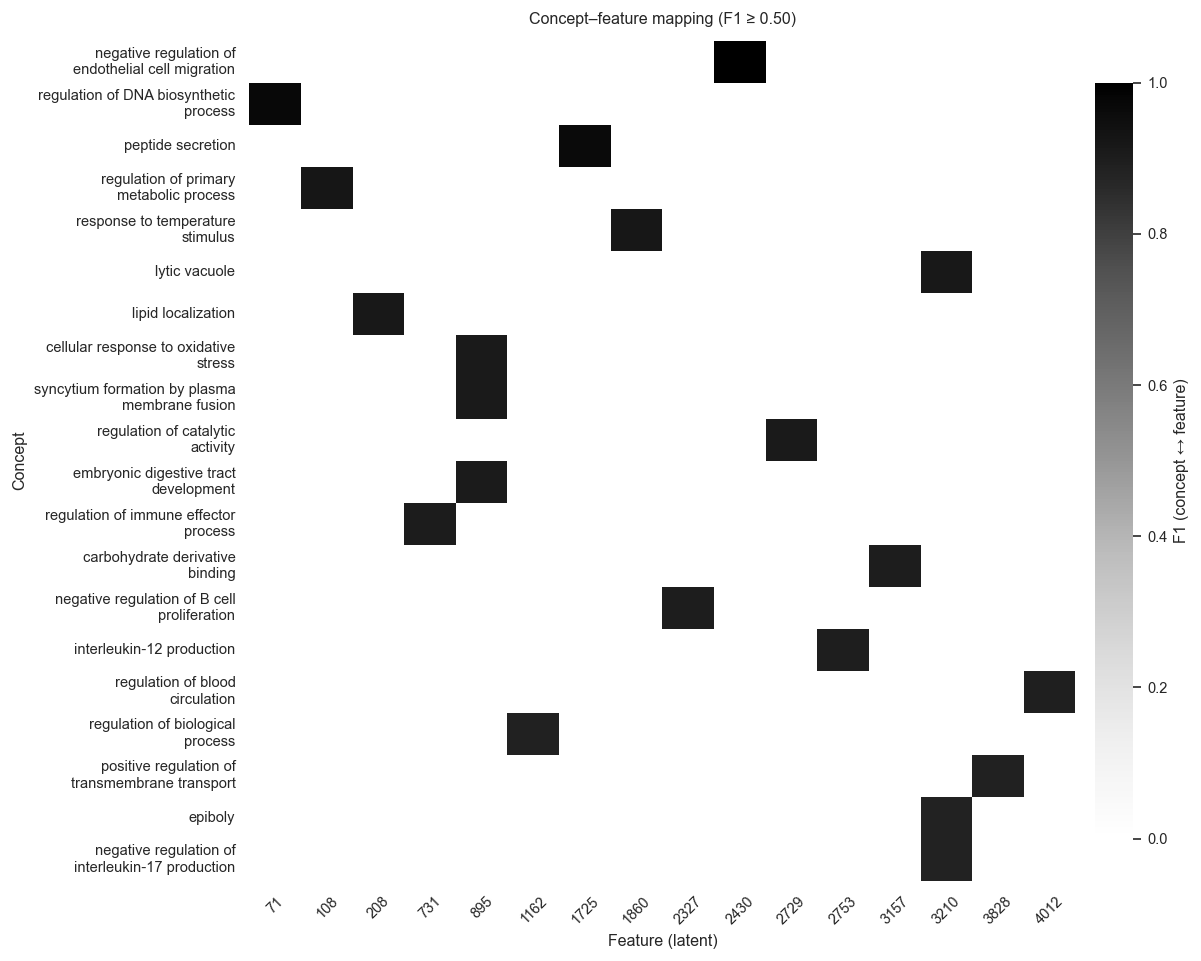

[done] Saved figures + tables to: /maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/figures


In [4]:
# === Concept–Feature mapping (F1) — Illustrator-friendly figures ===
# - Filters out concepts with >6 words in the name
# - Uses consistent, journal/grayscale style
# - Saves SVG/PDF with editable text + PNG preview

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# ------------------------
# Config
# ------------------------
OUTDIR = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/figures"
os.makedirs(OUTDIR, exist_ok=True)

# Thresholds & selections
F1_CUTOFF        = 0.50     # keep concept–feature links with F1 ≥ this
TOP_N_CONCEPTS   = 20       # take the top-N concepts by (support, maxF1, sumF1)
TOP_M_LATENTS    = None     # None = keep all columns that appear at least once


# Consistent grayscale plotting defaults
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "axes.edgecolor": "0.2",
    "axes.labelcolor": "0.1",
    "text.color": "0.1",
    "grid.color": "0.75",
    "grid.linestyle": "--",
    "grid.linewidth": 0.7,
})

# ------------------------
# Load F1 table
# ------------------------
# Expect columns: ['feature', 'concept', 'f1', ...]
# If you already have f1_df in memory, this block will skip loading.
if "f1_df" not in globals():
    F1_CSV_PATH = "/maiziezhou_lab2/yunfei/Projects/FM_temp/interGFM/output/test/heldout_top_pairings.csv"
    f1_df = pd.read_csv(F1_CSV_PATH, index_col=0)

# ------------------------
# # 1) Coverage sweep (optional but useful)
# # ------------------------
# def plot_coverage_sweep(f1_df, outdir):
#     thresholds = np.linspace(0, 1, 50)
#     concept_counts = []
#     latent_counts = []

#     for t in thresholds:
#         sub = f1_df[f1_df["f1"] > t]
#         concept_counts.append(sub["concept"].nunique())
#         latent_counts.append(sub["feature"].nunique())

#     fig, ax = plt.subplots(figsize=(6.2, 4.0))
#     ax.plot(thresholds, concept_counts, marker="o", lw=1.5, label="# Concepts", color="0.2")
#     ax.plot(thresholds, latent_counts, marker="s", lw=1.5, label="# Latents", color="0.5")
#     ax.set_xlabel("F1 threshold")
#     ax.set_ylabel("Count")
#     ax.set_title("Concept and latent coverage vs. F1 threshold")
#     ax.grid(True, linestyle="--", alpha=0.5)
#     ax.legend(frameon=False)
#     fig.tight_layout()

#     fig.savefig(os.path.join(outdir, "coverage_sweep.svg"), bbox_inches="tight")
#     fig.savefig(os.path.join(outdir, "coverage_sweep.pdf"), bbox_inches="tight")
#     fig.savefig(os.path.join(outdir, "coverage_sweep.png"), bbox_inches="tight", dpi=300)
#     plt.show()

# plot_coverage_sweep(f1_df, OUTDIR)

# ------------------------
# 2) Build F1 matrix at chosen cutoff
# ------------------------
subset = f1_df[f1_df["f1"] >= F1_CUTOFF]
M = subset.pivot_table(index="concept", columns="feature", values="f1", fill_value=0.0)

# ------------------------
# 3) Drop concepts with >6 words
# ------------------------
def _word_count(name: str) -> int:
    s = str(name).replace("_", " ").replace("-", " ")
    return len([w for w in s.split() if w])

max_words = 6
keep_concepts = [c for c in M.index if _word_count(c) <= max_words]
dropped = sorted(set(M.index) - set(keep_concepts))
if dropped:
    print(f"[filter] Dropping {len(dropped)} overlong concepts (> {max_words} words).")
    pd.Series(dropped, name="dropped_concept").to_csv(
        os.path.join(OUTDIR, f"dropped_concepts_gt{max_words}words.csv"),
        index=False
    )
M = M.loc[keep_concepts]

# ------------------------
# 4) Rank concepts by support + strength, pick top-N
# ------------------------
concept_stats = pd.DataFrame({
    "support": (M > 0).sum(axis=1),  # #features matched at cutoff
    "maxF1":   M.max(axis=1),
    "sumF1":   M.sum(axis=1),
}).sort_values(["support", "maxF1", "sumF1"], ascending=False)

keep_rows = concept_stats.index[:TOP_N_CONCEPTS]
M_rows = M.loc[keep_rows]

# keep only columns (features) that appear at least once
cols_used = M_rows.columns[(M_rows > 0).any(axis=0)]
if TOP_M_LATENTS is not None:
    col_stats = (M_rows > 0).sum(axis=0).sort_values(ascending=False)
    keep_cols = col_stats.index[:TOP_M_LATENTS]
else:
    keep_cols = cols_used

M_plot = M_rows[keep_cols]   # rows = concepts, cols = features

# ------------------------
# 5) Plot heatmap (Illustrator-ready)
# ------------------------
sns.set_theme(context="paper", style="white", font_scale=1.0)

# Size scales with content
n_rows, n_cols = M_plot.shape
PANEL_SCALE = 1.35
height = np.clip(0.36 * n_rows * PANEL_SCALE, 7.0, 22.0)   # rows = concepts
width  = np.clip(0.48 * n_cols * PANEL_SCALE, 10.0, 30.0)  # cols = features

fig, ax = plt.subplots(figsize=(width, height))

# Grayscale colormap for consistency with earlier figures
hm = sns.heatmap(
    M_plot, ax=ax,
    cmap="Greys", vmin=0.0, vmax=1.0,
    cbar_kws={"label": "F1 (concept ↔ feature)", "shrink": 0.9, "pad": 0.02},
    square=False, linewidths=0
)

ax.set_xlabel("Feature (latent)")
ax.set_ylabel("Concept")
ax.set_title(f"Concept–feature mapping (F1 ≥ {F1_CUTOFF:.2f})", pad=10)

# Wrap long concept names (y-ticks)
wrap_width = 30
yt = ax.get_yticklabels()
wrapped_y = [textwrap.fill(t.get_text(), wrap_width) for t in yt]
ax.set_yticklabels(wrapped_y, rotation=0, va="center")

# Sparsify x-ticks if many features
every_xtick = max(1, int(np.ceil(n_cols / 40)))
for i, lab in enumerate(ax.get_xticklabels()):
    lab.set_visible(i % every_xtick == 0)
ax.tick_params(axis='x', rotation=45, labelrotation=45)

fig.subplots_adjust(left=0.18, right=0.98, top=0.92, bottom=0.20)

# Save vector + raster
# fig.savefig(os.path.join(OUTDIR, "concept_feature_heatmap.svg"), bbox_inches="tight")
fig.savefig(os.path.join(OUTDIR, "concept_feature_heatmap.pdf"), bbox_inches="tight")
# fig.savefig(os.path.join(OUTDIR, "concept_feature_heatmap.png"), bbox_inches="tight", dpi=300)
plt.show()

# ------------------------
# 6) Quick summary table (optional)
# ------------------------
summary = (
    subset.sort_values("f1", ascending=False)
          .groupby("feature").first()[["f1", "concept"]]
          .rename(columns={"f1": "max_F1", "concept": "top_concept"})
          .sort_values("max_F1", ascending=False)
)
summary.to_csv(os.path.join(OUTDIR, "feature_top_concept_at_cutoff.csv"))
print(f"[done] Saved figures + tables to: {OUTDIR}")

# scGPT activations comparison

In [5]:
import scanpy as sc
import pandas as pd
import torch

# Metadata: cell-gene pairs
meta_df = pd.read_csv(
    "/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/gene_ids/shard_0/cell_gene_pairs.txt",
    sep="\t", header=None, names=["cell_id", "gene_id"]
)

f1_df = pd.read_csv('/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/output_acts/test/heldout_top_pairings.csv', index_col=0)

# SAE Latents
# latents_df = pd.read_parquet("/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/activations/layer_4/shard_0/sae_latents.parquet")

# acts 
acts_df = torch.load("/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/activations/layer_4/shard_0/activations.pt")

# Load h5ad to get cell types
adata = sc.read_h5ad("/maiziezhou_lab2/yunfei/Projects/FM_temp/InterPLM/interplm/ge_shards/cosmx_human_lung_sec8.h5ad")
celltype_map = adata.obs["author_cell_type"].to_dict()  # dict: cell_id → cell_type

# Add cell_type to meta_df
meta_df["cell_type"] = meta_df["cell_id"].map(celltype_map)

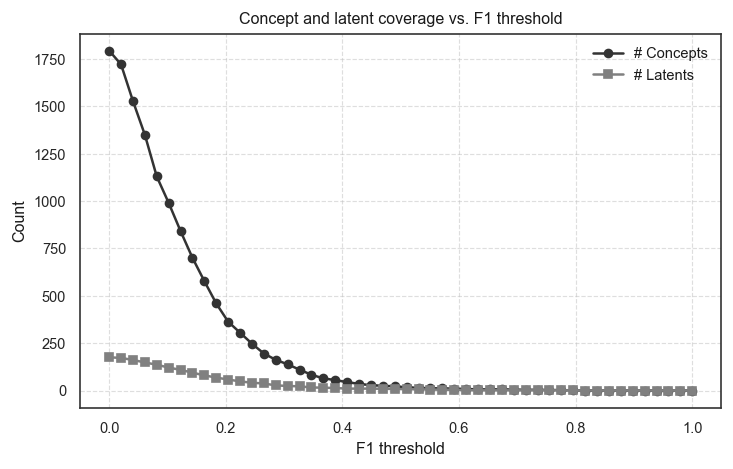

[filter] Dropping 1 concepts with > 6 words.


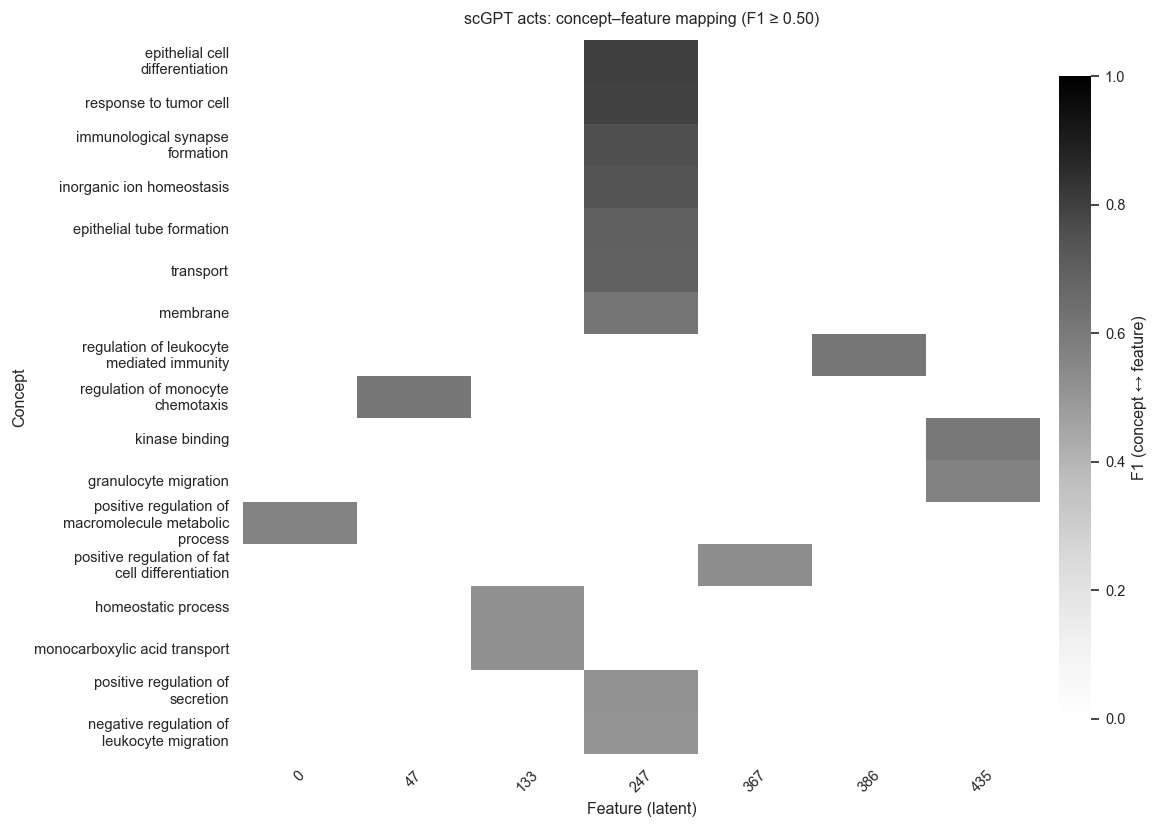

[done] Saved figures + tables to: /maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/figures_acts


In [6]:
# === scGPT acts: Concept–Feature (latent) F1 mapping — Illustrator-friendly ===
# - Uses F1 ≥ 0.60 cutoff
# - Drops concepts with names > 6 words (readability)
# - Grayscale style, text fully editable in PDF/SVG
# - Saves coverage sweep + heatmap + summary CSV

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# ------------------------
# Config
# ------------------------
OUTDIR = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/figures_acts"
os.makedirs(OUTDIR, exist_ok=True)

F1_CUTOFF        = 0.50     # main cutoff for links
TOP_N_CONCEPTS   = 20       # top-N concepts after ranking by (support, maxF1, sumF1)
TOP_M_LATENTS    = None     # None = keep all columns that appear at least once

# Illustrator-friendly typography (editable text in PDF/SVG)
# BASE = 12
# mpl.rcParams.update({
#     "pdf.fonttype": 42,       # keep text vectors (editable)
#     "ps.fonttype": 42,
#     "svg.fonttype": "none",   # keep <text> as text
#     "font.family": "Arial",
#     "font.size": BASE,
#     "axes.titlesize": BASE + 1,
#     "axes.labelsize": BASE,
#     "xtick.labelsize": BASE - 1,
#     "ytick.labelsize": BASE - 1,
#     "legend.fontsize": BASE - 1,
#     "axes.linewidth": 0.7,
#     "xtick.major.width": 0.6,
#     "ytick.major.width": 0.6,
# })
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "axes.edgecolor": "0.2",
    "axes.labelcolor": "0.1",
    "text.color": "0.1",
    "grid.color": "0.75",
    "grid.linestyle": "--",
    "grid.linewidth": 0.7,
})

# ------------------------
# Load scGPT F1 table
# ------------------------
# Expect columns: ['feature', 'concept', 'f1', ...]
if "f1_df" not in globals():
    F1_CSV_PATH = "/path/to/your/scgpt/acts_f1_table.csv"
    f1_df = pd.read_csv(F1_CSV_PATH, index_col=0)

# ------------------------
# Coverage sweep (optional comparison plot)
# ------------------------
def plot_coverage_sweep(f1_df, outdir, title="Concept and latent coverage vs. F1 threshold"):
    thresholds = np.linspace(0, 1, 50)
    concept_counts, latent_counts = [], []
    for t in thresholds:
        sub = f1_df[f1_df["f1"] > t]
        concept_counts.append(sub["concept"].nunique())
        latent_counts.append(sub["feature"].nunique())

    fig, ax = plt.subplots(figsize=(6.2, 4.0))
    ax.plot(thresholds, concept_counts, marker="o", lw=1.5, label="# Concepts", color="0.2")
    ax.plot(thresholds, latent_counts, marker="s", lw=1.5, label="# Latents", color="0.5")
    ax.set_xlabel("F1 threshold")
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(frameon=False)
    fig.tight_layout()
    fig.savefig(os.path.join(outdir, "scgpt_coverage_sweep.svg"), bbox_inches="tight")
    fig.savefig(os.path.join(outdir, "scgpt_coverage_sweep.pdf"), bbox_inches="tight")
    fig.savefig(os.path.join(outdir, "scgpt_coverage_sweep.png"), bbox_inches="tight", dpi=300)
    plt.show()

plot_coverage_sweep(f1_df, OUTDIR)

# ------------------------
# Build F1 matrix at cutoff
# ------------------------
subset = f1_df[f1_df["f1"] >= F1_CUTOFF]
M = subset.pivot_table(index="concept", columns="feature", values="f1", fill_value=0.0)

# ------------------------
# Drop concepts with >6 words
# ------------------------
def _word_count(name: str) -> int:
    s = str(name).replace("_", " ").replace("-", " ")
    return len([w for w in s.split() if w])

max_words = 6
keep_concepts = [c for c in M.index if _word_count(c) <= max_words]
dropped = sorted(set(M.index) - set(keep_concepts))
if dropped:
    print(f"[filter] Dropping {len(dropped)} concepts with > {max_words} words.")
    pd.Series(dropped, name="dropped_concept").to_csv(
        os.path.join(OUTDIR, f"scgpt_dropped_concepts_gt{max_words}words.csv"),
        index=False
    )
M = M.loc[keep_concepts]

# ------------------------
# Rank concepts & select rows/cols
# ------------------------
concept_stats = pd.DataFrame({
    "support": (M > 0).sum(axis=1),
    "maxF1":   M.max(axis=1),
    "sumF1":   M.sum(axis=1),
}).sort_values(["support", "maxF1", "sumF1"], ascending=False)

keep_rows = concept_stats.index[:TOP_N_CONCEPTS]
M_rows = M.loc[keep_rows]

cols_used = M_rows.columns[(M_rows > 0).any(axis=0)]
if TOP_M_LATENTS is not None:
    col_stats = (M_rows > 0).sum(axis=0).sort_values(ascending=False)
    keep_cols = col_stats.index[:TOP_M_LATENTS]
else:
    keep_cols = cols_used

M_plot = M_rows[keep_cols]   # rows = concepts, cols = features

# ------------------------
# Heatmap (grayscale, Illustrator-ready)
# ------------------------
sns.set_theme(context="paper", style="white", font_scale=1.0)

n_rows, n_cols = M_plot.shape
PANEL_SCALE = 1.35
height = np.clip(0.36 * n_rows * PANEL_SCALE, 7.0, 22.0)
width  = np.clip(0.48 * n_cols * PANEL_SCALE, 10.0, 30.0)

fig, ax = plt.subplots(figsize=(width, height))
hm = sns.heatmap(
    M_plot, ax=ax,
    cmap="Greys", vmin=0.0, vmax=1.0,
    cbar_kws={"label": "F1 (concept ↔ feature)", "shrink": 0.9, "pad": 0.02},
    square=False, linewidths=0
)
ax.set_xlabel("Feature (latent)")
ax.set_ylabel("Concept")
ax.set_title(f"scGPT acts: concept–feature mapping (F1 ≥ {F1_CUTOFF:.2f})", pad=10)

# Wrap long concept names (y-ticks)
wrap_width = 30
yt = ax.get_yticklabels()
wrapped_y = [textwrap.fill(t.get_text(), wrap_width) for t in yt]
ax.set_yticklabels(wrapped_y, rotation=0, va="center")

# Sparsify x-ticks if many features
every_xtick = max(1, int(np.ceil(n_cols / 40)))
for i, lab in enumerate(ax.get_xticklabels()):
    lab.set_visible(i % every_xtick == 0)
ax.tick_params(axis="x", rotation=45, labelrotation=45)

fig.subplots_adjust(left=0.18, right=0.98, top=0.92, bottom=0.20)

fig.savefig(os.path.join(OUTDIR, "scgpt_concept_feature_heatmap.svg"), bbox_inches="tight")
fig.savefig(os.path.join(OUTDIR, "scgpt_concept_feature_heatmap.pdf"), bbox_inches="tight")
fig.savefig(os.path.join(OUTDIR, "scgpt_concept_feature_heatmap.png"), bbox_inches="tight", dpi=300)
plt.show()

# ------------------------
# Summary table (per-feature max F1 concept at cutoff)
# ------------------------
summary = (
    subset.sort_values("f1", ascending=False)
          .groupby("feature").first()[["f1", "concept"]]
          .rename(columns={"f1": "max_F1", "concept": "top_concept"})
          .sort_values("max_F1", ascending=False)
)
summary.to_csv(os.path.join(OUTDIR, "scgpt_feature_top_concept_at_cutoff.csv"))
print(f"[done] Saved figures + tables to: {OUTDIR}")

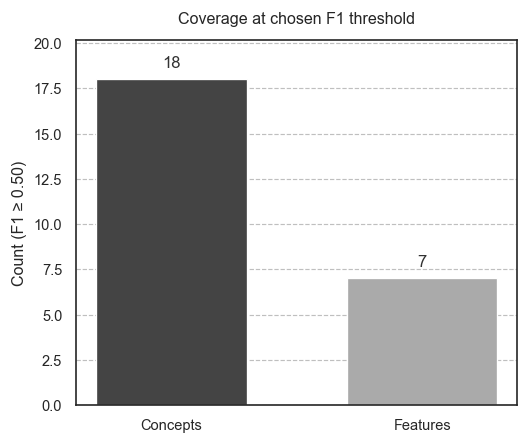

In [11]:

# --- Compute coverage at chosen F1 threshold ---
F1_THRESHOLD = 0.5  # or 0.6 depending on your setting

subset = f1_df[f1_df["f1"] >= F1_THRESHOLD]
n_concepts = subset["concept"].nunique()
n_features = subset["feature"].nunique()

# --- Plot ---
fig, ax = plt.subplots(figsize=(4.5, 3.8))
bars = ax.bar(
    ["Concepts", "Features"],
    [n_concepts, n_features],
    color=["#444444", "#aaaaaa"],
    width=0.6
)

ax.set_ylabel(f"Count (F1 ≥ {F1_THRESHOLD:.2f})")
ax.set_title("Coverage at chosen F1 threshold", pad=10)
ax.grid(True, axis="y", linestyle="--", linewidth=0.7, color="0.75")
ax.set_axisbelow(True)


# Annotate counts above bars
def annotate_bars(ax, bars, fmt="{:.0f}", pad=0.6, inside=False):
    """
    Place labels on bars.
    - pad: vertical padding in data units
    - inside=False -> above the bar; inside=True -> inside top of bar (white text)
    """
    # add headroom so labels above bars aren't cut off
    heights = [b.get_height() for b in bars]
    y_max = max(heights)
    ax.set_ylim(top=y_max * 1.12)

    for b in bars:
        x = b.get_x() + b.get_width() / 2
        h = b.get_height()
        if inside:
            ax.text(x, h - pad, fmt.format(h), ha="center", va="top",
                    color="white", fontsize=10, clip_on=False)
        else:
            ax.text(x, h + pad, fmt.format(h), ha="center", va="bottom",
                    color="0.2", fontsize=10, clip_on=False)

annotate_bars(ax, bars, fmt="{:.0f}", pad=0.5, inside=False)
plt.tight_layout()

# --- Save (vector-editable) ---
# plt.savefig("coverage_barplot.svg", bbox_inches="tight")
# plt.savefig("coverage_barplot.pdf", bbox_inches="tight")
plt.show()

Features with max_F1 ≥ 0.5: 7


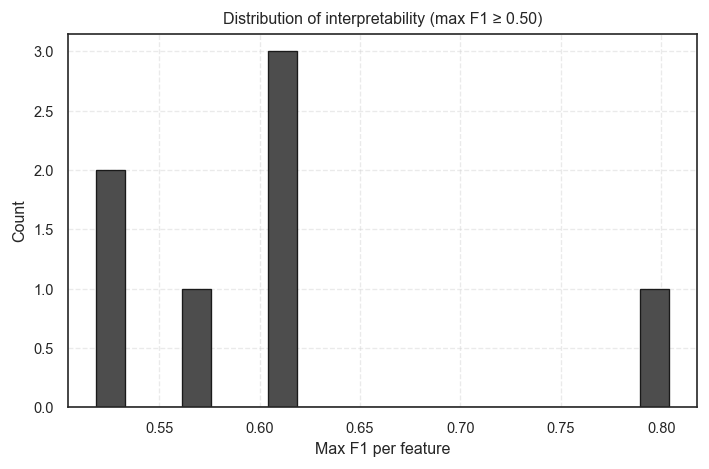

In [8]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os

F1_CUTOFF = 0.50  # adjust as needed

def plot_maxF1_histogram(f1_df, cutoff=F1_CUTOFF, outdir=OUTDIR,
                         title=f"Distribution of interpretability (max F1 ≥ {F1_CUTOFF:.2f})"):
    # per-feature max F1 and associated top concept
    f1_summary = (
        f1_df.sort_values("f1", ascending=False)
             .groupby("feature")
             .first()[["f1","concept"]]
             .rename(columns={"f1":"max_F1","concept":"top_concept"})
    )
    high = f1_summary.query("max_F1 >= @cutoff")

    print(f"Features with max_F1 ≥ {cutoff}: {len(high)}")
    # Save the table used for the figure
    high.to_csv(os.path.join(outdir, f"maxF1_ge_{cutoff:.2f}.csv"))

    fig, ax = plt.subplots(figsize=(6.0, 4.0))
    ax.hist(high["max_F1"], bins=20, color="0.3", edgecolor="0.1", linewidth=0.8)
    ax.set_xlabel("Max F1 per feature")
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.4)
    fig.tight_layout()
    # fig.savefig(os.path.join(outdir, f"maxF1_hist_ge_{cutoff:.2f}.svg"), bbox_inches="tight")
    fig.savefig(os.path.join(outdir, f"maxF1_hist_ge_{cutoff:.2f}.pdf"), bbox_inches="tight")
    # fig.savefig(os.path.join(outdir, f"maxF1_hist_ge_{cutoff:.2f}.png"), bbox_inches="tight", dpi=300)
    plt.show()

# Run
plot_maxF1_histogram(f1_df, cutoff=F1_CUTOFF)

Features with max_F1 > 0.6: 4


,max_F1,top_concept
feature,,
247,0.803715,epithelial cell differentiation
386,0.613393,regulation of leukocyte mediated immunity
47,0.611371,regulation of monocyte chemotaxis
435,0.607196,kinase binding


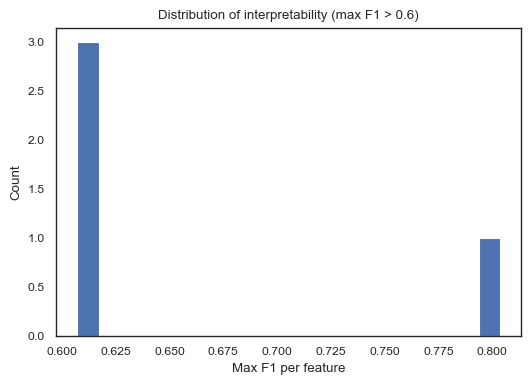

In [14]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Group by feature and take the row with the max F1
f1_summary = (
    f1_df.sort_values("f1", ascending=False)
         .groupby("feature")
         .first()  # keep highest-F1 row per feature
)

summary = f1_summary[["f1", "concept"]].rename(
    columns={"f1": "max_F1", "concept": "top_concept"}
).sort_values("max_F1", ascending=False)

# Filter features with max_F1 > 0.75
high_f1_features = summary.query("max_F1 > 0.6")

print(f"Features with max_F1 > 0.6: {len(high_f1_features)}")
display(high_f1_features)

plt.figure(figsize=(6, 4))
plt.hist(high_f1_features["max_F1"], bins=20)
plt.xlabel("Max F1 per feature")
plt.ylabel("Count")
plt.title("Distribution of interpretability (max F1 > 0.6)")
plt.show()

# Optional: save to CSV for inspection
# high_f1_features.to_csv("/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/high_f1_0.75_concepts.csv")
